## Setup: Libraries, Style, and File Paths

In this section, we import all required libraries for the project:
- pandas / numpy for data handling and numerical operations
- matplotlib / seaborn for visualization

We also define a consistent global plotting style (theme + default figure size) to keep all graphs uniform across the notebook.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 6)

from pathlib import Path

PROJECT_ROOT = Path().resolve()

DATA_DIR = PROJECT_ROOT / "data"
RAW_PATH = DATA_DIR / "raw" / "healthcare-dataset-stroke-data.csv"
PROCESSED_PATH = DATA_DIR / "processed" / "stroke_clean_v1.csv"

## Data Cleaning (Raw → Processed)

This function creates the cleaned dataset used throughout the project.

Cleaning steps:
1. Load the raw CSV file.
2. Remove the single row where gender == "Other" (extremely rare category).
3. Fill missing values in bmi using the median (robust to outliers).
4. Convert selected categorical columns to category dtype (helps memory and ensures consistent handling).

In [69]:
def build_clean_dataset(raw_path: str) -> pd.DataFrame:
    df = pd.read_csv(raw_path)

    # remove "Other" in gender
    if "gender" in df.columns:
        df = df[df["gender"] != "Other"].copy()

    # fill BMI missing with median
    if "bmi" in df.columns:
        bmi_median = df["bmi"].median()
        df["bmi"] = df["bmi"].fillna(bmi_median)

    # set categories
    cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype("category")

    return df

## Run Cleaning and Save the Processed Dataset

Here we run the cleaning code and save the cleaned dataset to a processed CSV file. This processed version will be used for all further analysis and visualizations.

In [70]:
from pathlib import Path

if PROCESSED_PATH.exists():
    df = pd.read_csv(PROCESSED_PATH)
    print("Loaded processed dataset:", PROCESSED_PATH)
else:
    df = build_clean_dataset(RAW_PATH)
    print("Built dataset from raw file. Shape:", df.shape)
    df.to_csv(PROCESSED_PATH, index=False)
    print("Saved processed dataset:", PROCESSED_PATH)

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\AppData\\Local\\Packages\\5319275A.WhatsAppDesktop_cv1g1gvanyjgm\\LocalState\\sessions\\770D9287370B556BB1AC7E7813FEA0E8AECA0921\\transfers\\2026-04\\data\\raw\\healthcare-dataset-stroke-data.csv'

## Exploratory Data Analysis (EDA): Key Continuous Risk Factors

We compare stroke vs. non-stroke groups across three continuous variables: Age, Avg Glucose Level, BMI.

For each variable, we show:

Overlaid histograms (distribution shape in each group)

Boxplots (median, spread, and outliers)

This gives a fast visual summary of which variables show the strongest separation between groups.

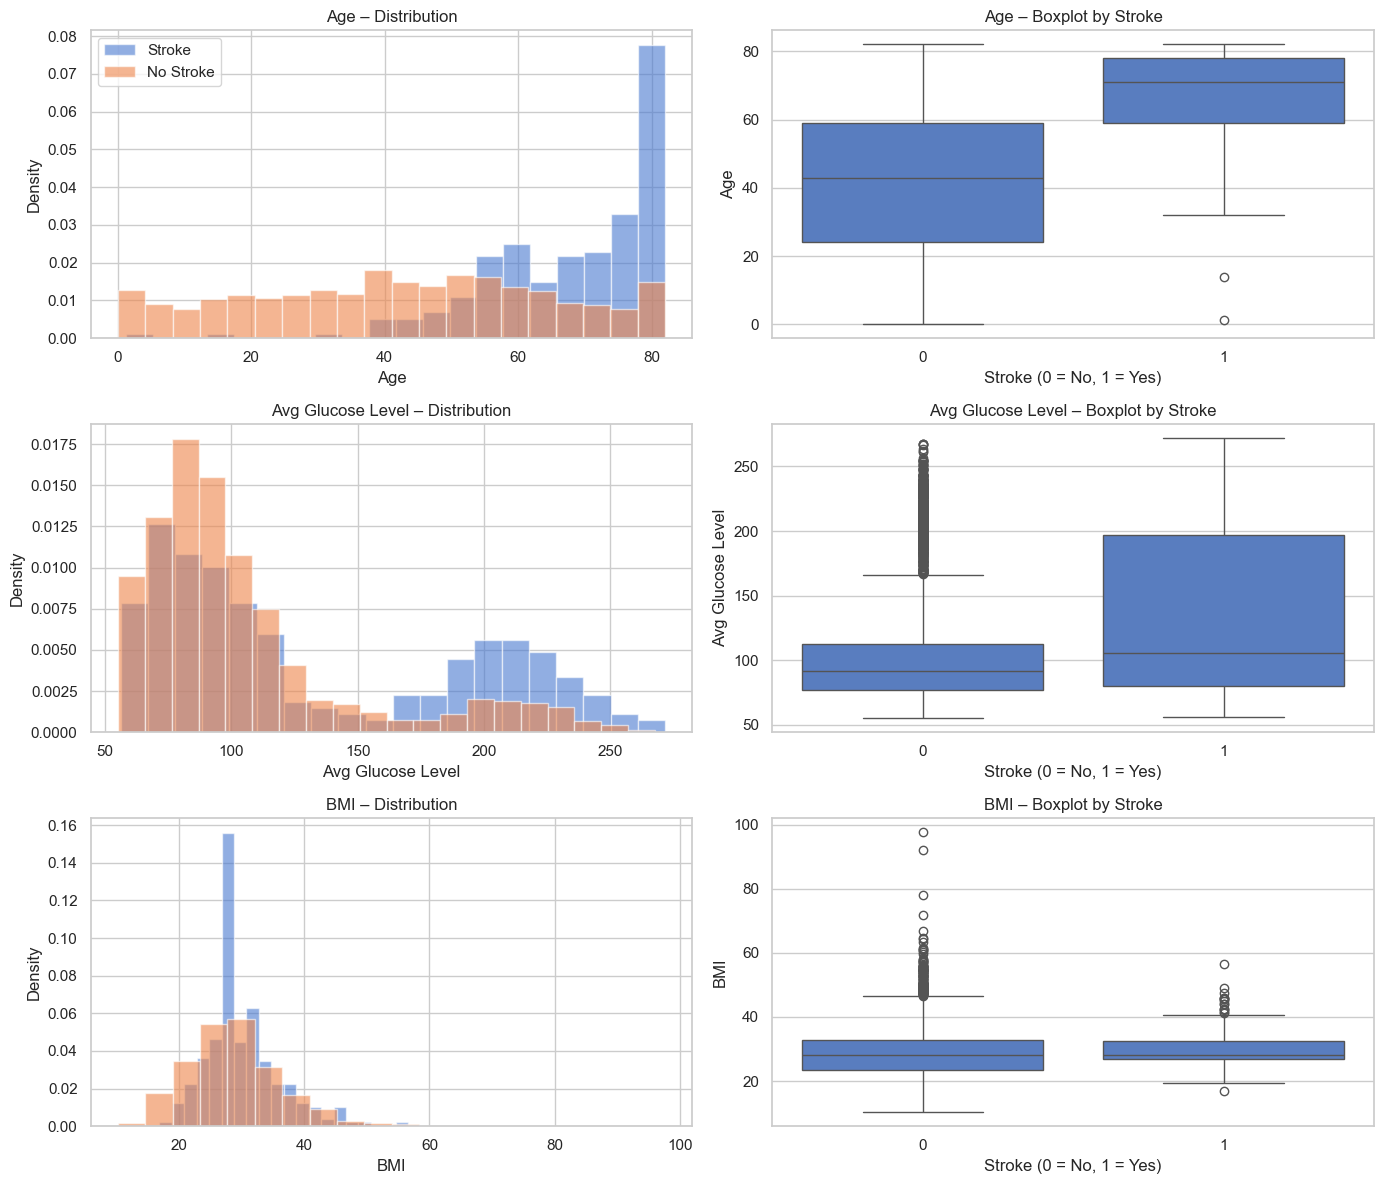

In [ ]:
# EDA: Histograms + Boxplots
stroke_df = df[df["stroke"] == 1]
no_stroke_df = df[df["stroke"] == 0]

features = [
    ("age", "Age"),
    ("avg_glucose_level", "Avg Glucose Level"),
    ("bmi", "BMI")
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

for i, (col, label) in enumerate(features):

    # Histogram 
    axes[i, 0].hist(
        stroke_df[col].dropna(),
        bins=20,
        density=True,
        alpha=0.6,
        label="Stroke"
    )
    axes[i, 0].hist(
        no_stroke_df[col].dropna(),
        bins=20,
        density=True,
        alpha=0.6,
        label="No Stroke"
    )
    axes[i, 0].set_title(f"{label} – Distribution")
    axes[i, 0].set_xlabel(label)
    axes[i, 0].set_ylabel("Density")

    if i == 0:
        axes[i, 0].legend()

    # Boxplot 
    sns.boxplot(
        x="stroke",
        y=col,
        data=df,
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"{label} – Boxplot by Stroke")
    axes[i, 1].set_xlabel("Stroke (0 = No, 1 = Yes)")
    axes[i, 1].set_ylabel(label)

plt.tight_layout()
plt.show()

## Key Findings from EDA

- Stroke patients tend to be older compared to non-stroke individuals.
- Average glucose levels are higher in the stroke group, with a noticeable rightward shift.
- BMI shows a weaker separation between groups, with substantial overlap.


## Cross-Validation for Data Stability Check

To verify that the observed age–stroke trend is stable and not driven by a specific subset of the dataset, we performed repeated random half-sample splits of the data. In each run, the dataset was randomly divided into two disjoint groups (Sample A and Sample B), each containing approximately 50% of the observations. This procedure was repeated 100 times using different random seeds to account for sampling variability. For every split, we computed the stroke rate within age bins for both samples and summarized the results by plotting the mean stroke probability across all runs together with 95% variability bands for each age group. 

**Bottom Line:** The age–stroke relationship remains consistent across repeated random subsets of the data.

**Interpretation:** Across all random splits, both samples display a similar monotonic increase in stroke probability with age. The close overlap between the two independent samples and the relatively narrow variability bands indicate that the observed age–stroke trend is stable, reproducible, and not an artifact of a particular subset of individuals. The uncertainty bands widen slightly at older ages, which is expected due to smaller sample sizes in these age groups, yet the overall upward trend remains clear.

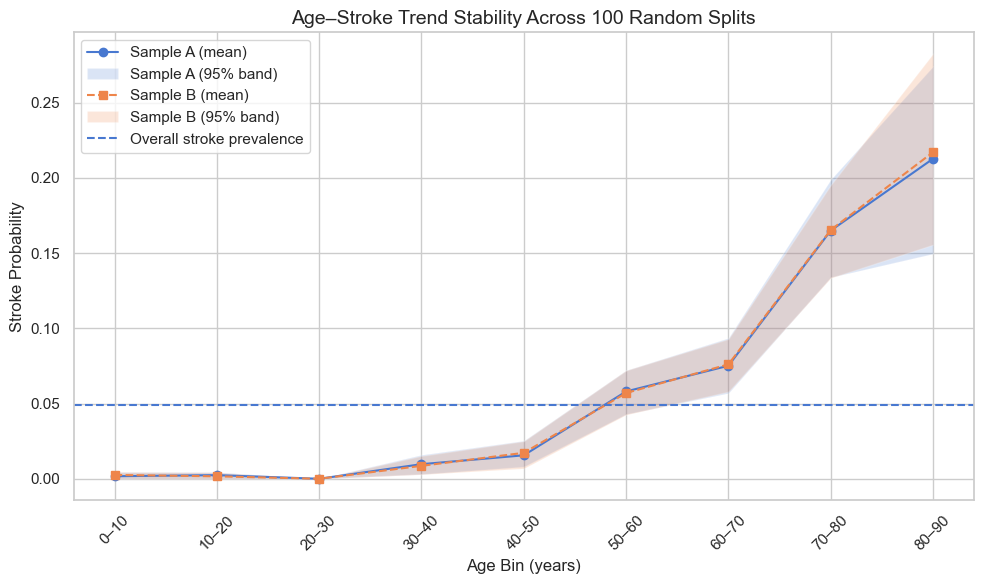

In [ ]:
N_RUNS = 100
bins = list(range(0, 101, 10))
bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins) - 1)]

def safe_rate(g, min_n=10):
    return g.mean() if len(g) >= min_n else np.nan

rates_a = []
rates_b = []

for seed in range(N_RUNS):
    rng = np.random.default_rng(seed)
    mask = rng.random(len(df)) < 0.5

    sample_a = df[mask].copy()
    sample_b = df[~mask].copy()

    sample_a["age_bin"] = pd.cut(sample_a["age"], bins=bins, include_lowest=True, right=False)
    sample_b["age_bin"] = pd.cut(sample_b["age"], bins=bins, include_lowest=True, right=False)

    cats = sample_a["age_bin"].cat.categories

    ra = sample_a.groupby("age_bin", observed=False)["stroke"].apply(safe_rate).reindex(cats)
    rb = sample_b.groupby("age_bin", observed=False)["stroke"].apply(safe_rate).reindex(cats)

    rates_a.append(ra.values)
    rates_b.append(rb.values)

rates_a = np.array(rates_a, dtype=float)
rates_b = np.array(rates_b, dtype=float)

valid_a = np.any(~np.isnan(rates_a), axis=0)
valid_b = np.any(~np.isnan(rates_b), axis=0)
valid = valid_a | valid_b

rates_a = rates_a[:, valid]
rates_b = rates_b[:, valid]
labels = [lab for lab, ok in zip(bin_labels, valid) if ok]

mean_a = np.nanmean(rates_a, axis=0)
low_a  = np.nanpercentile(rates_a, 2.5, axis=0)
high_a = np.nanpercentile(rates_a, 97.5, axis=0)

mean_b = np.nanmean(rates_b, axis=0)
low_b  = np.nanpercentile(rates_b, 2.5, axis=0)
high_b = np.nanpercentile(rates_b, 97.5, axis=0)

x = np.arange(len(labels))

plt.figure(figsize=(10, 6))

plt.plot(x, mean_a, marker="o", label="Sample A (mean)")
plt.fill_between(x, low_a, high_a, alpha=0.2, label="Sample A (95% band)")

plt.plot(x, mean_b, marker="s", linestyle="--", label="Sample B (mean)")
plt.fill_between(x, low_b, high_b, alpha=0.2, label="Sample B (95% band)")

plt.axhline(df["stroke"].mean(), linestyle="--", label="Overall stroke prevalence")

plt.xticks(x, labels, rotation=45)
plt.title(f"Age–Stroke Trend Stability Across {N_RUNS} Random Splits", fontsize=14)
plt.xlabel("Age Bin (years)")
plt.ylabel("Stroke Probability")
plt.legend()
plt.tight_layout()
plt.show()

### Summary Statistics (Mean and Median)

To complement the visual exploration, we report summary statistics for key continuous variables.
These values provide a numerical comparison between stroke and non-stroke groups.


In [ ]:
summary_stats = (
    df
    .groupby("stroke")[["age", "avg_glucose_level", "bmi"]]
    .agg(["mean", "median"])
    .round(2)
)

summary_stats

age        avg_glucose_level            bmi       
         mean median              mean  median   mean median
stroke                                                      
0       41.97   43.0            104.79   91.46  28.80   28.1
1       67.73   71.0            132.54  105.22  30.09   28.1

## Glucose Tipping Point 

In this section, we investigate whether stroke risk increases non-linearly as average glucose level rises.

We group avg_glucose_level into bins (intervals) and compute the mean stroke rate in each bin.
The results are plotted as a line chart to identify glucose ranges where stroke probability appears to increase more sharply.

### **Bottom Line**

Stroke probability increases with higher average glucose levels, particularly in the upper ranges.

### **Interpretation**

The relationship between glucose level and stroke risk is not strictly linear. Stroke probability remains relatively stable at lower glucose ranges but rises more noticeably in higher bins, suggesting a possible threshold or tipping-point effect at elevated glucose levels. The dashed line indicates the global average stroke risk, the overall prevalence of stroke in the dataset, serving as a baseline for comparison across glucose levels.

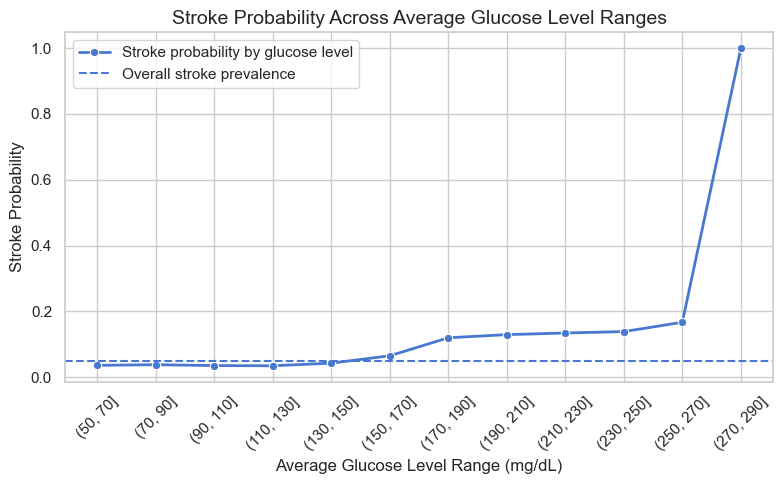

In [ ]:
bins = np.arange(50, 291, 20)

df["glucose_bin"] = pd.cut(df["avg_glucose_level"], bins=bins, include_lowest=True)

glucose_risk = (
    df.groupby("glucose_bin", observed=False)["stroke"]
    .mean()
    .reset_index()
)

glucose_risk_plot = glucose_risk.copy()

def fmt_interval(iv):
    left = int(round(iv.left))
    right = int(round(iv.right))
    if left == right:
        left = int(iv.left)
        right = int(iv.right)
    return f"({left}, {right}]"

glucose_risk_plot["glucose_bin_str"] = glucose_risk_plot["glucose_bin"].apply(fmt_interval)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=glucose_risk_plot,
    x="glucose_bin_str",
    y="stroke",
    marker="o",
    linewidth=2,
    label="Stroke probability by glucose level"
)

plt.axhline(df["stroke"].mean(), linestyle="--", label="Overall stroke prevalence")
plt.xticks(rotation=45)
plt.title("Stroke Probability Across Average Glucose Level Ranges", fontsize=14)
plt.xlabel("Average Glucose Level Range (mg/dL)")
plt.ylabel("Stroke Probability")
plt.legend()
plt.tight_layout()
plt.show()

## Multiplier Effect: Interaction Feature (Age × Glucose)

In this section, we test whether combining age and average glucose level into an interaction feature improves association with stroke.

We create a new variable Age_x_Glucose by multiplying age and avg_glucose_level, then compare the Pearson correlation of:
age, avg_glucose_level, and Age_x_Glucose with the stroke outcome.

This helps evaluate whether the combined effect of age and glucose provides a stronger signal than each factor alone.

### **Bottom Line**

The interaction term (Age × Glucose) does not substantially improve association beyond age alone.

### **Interpretation**

Although the combined feature reflects the joint influence of age and glucose, its correlation with stroke is nearly identical to that of age by itself. This suggests that most of the predictive signal in the interaction term is driven by age, and the added contribution of glucose is comparatively small in linear association terms.

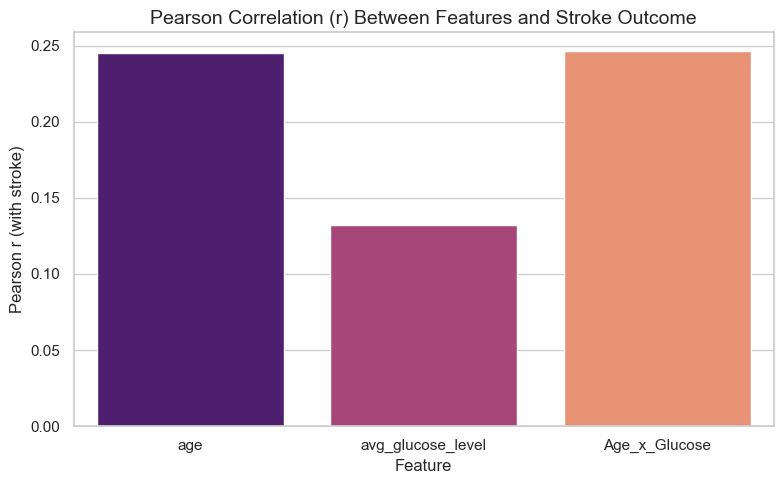

In [ ]:
df["Age_x_Glucose"] = df["age"] * df["avg_glucose_level"]

corrs = df[["age", "avg_glucose_level", "Age_x_Glucose", "stroke"]] \
    .corr(method="pearson", numeric_only=True)["stroke"] \
    .drop("stroke")

plt.figure(figsize=(8, 5))
sns.barplot(
    x=corrs.index,
    y=corrs.values,
    hue=corrs.index,
    legend=False,
    palette="magma"
)

plt.title("Pearson Correlation (r) Between Features and Stroke Outcome", fontsize=14)
plt.xlabel("Feature")
plt.ylabel("Pearson r (with stroke)")
plt.tight_layout()
plt.show()

## Categorical Risk Breakdown: Gender

In this section, we examine stroke percentages within each gender category.

### Bottom Line  
Stroke probability differs slightly across gender categories.

### Interpretation  
Any observed difference may reflect biological, behavioral, or age-related patterns, but gender alone is usually not among the strongest predictors compared to major medical risk factors.

In [ ]:
display(pd.crosstab(df["gender"], df["stroke"], normalize="index") * 100)

stroke,0,1
gender,,
Female,95.290581,4.709419
Male,94.893617,5.106383


## Categorical Risk Breakdown: Marital Status

Here we examine the percentage of stroke cases within each marital status category.

### Bottom Line  
Stroke probability appears higher among those who have been married.

### Interpretation  
This pattern is likely influenced by age, since married individuals in the dataset tend to be older on average.

In [ ]:
display(pd.crosstab(df["ever_married"], df["stroke"], normalize="index") * 100)

stroke,0,1
ever_married,,
No,98.348519,1.651481
Yes,93.438712,6.561288


## Confounding Variable Reveal: Marriage vs. Age

This boxplot compares the age distribution between people who have ever been married ("Yes") and those who have not ("No").  
The median age is annotated for each group.

The plot highlights a key confounding effect: the married group is substantially older on average, and since age is strongly associated with stroke risk, marriage can appear to be related to stroke even if it is mainly reflecting age differences rather than a direct causal effect.

### **Bottom Line**

Married individuals are substantially older on average than unmarried individuals.

### **Interpretation**

Because age is strongly associated with stroke risk, the apparent relationship between marital status and stroke is likely driven by age differences rather than a direct effect of marriage itself. 

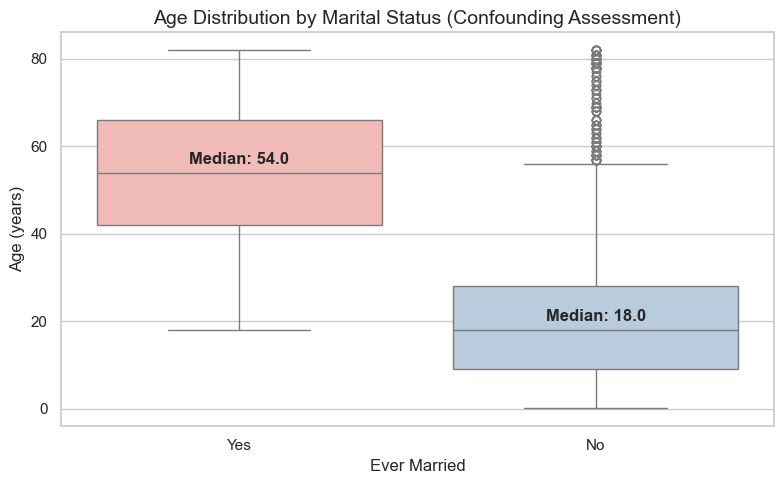

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="ever_married",
    y="age",
    data=df,
    hue="ever_married",
    palette="Pastel1",
    legend=False
)

plt.title("Age Distribution by Marital Status (Confounding Assessment)", fontsize=14)
plt.xlabel("Ever Married")
plt.ylabel("Age (years)")

median_yes = df[df["ever_married"] == "Yes"]["age"].median()
median_no = df[df["ever_married"] == "No"]["age"].median()

plt.text(0, median_yes + 2, f"Median: {median_yes:.1f}", ha="center", fontweight="bold")
plt.text(1, median_no + 2, f"Median: {median_no:.1f}", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

## Categorical Risk Breakdown: Residence Type and Work Type

In this section, we examine stroke percentages within residence and work categories separately.

### Bottom Line  
Residence type shows little difference, while work type displays clearer variation.

### Interpretation  
Place of residence alone does not appear strongly associated with stroke risk in this dataset. In contrast, work type may reflect socioeconomic or lifestyle differences that relate more meaningfully to health outcomes.

In [ ]:
display(pd.crosstab(df["Residence_type"], df["stroke"], normalize="index") * 100)

stroke,0,1
Residence_type,,
Rural,95.463589,4.536411
Urban,94.799692,5.200308


In [ ]:
display(pd.crosstab(df["work_type"], df["stroke"], normalize="index") * 100)

stroke,0,1
work_type,,
Govt_job,94.977169,5.022831
Never_worked,100.000000,0.000000
Private,94.904241,5.095759
Self-employed,92.063492,7.936508
children,99.708879,0.291121


## Lifestyle Stress Matrix (Work Type × Residence)

In this section, we examine whether stroke risk varies across combinations of work type and residence type.

We compute a pivot table where each cell represents the mean stroke rate for a specific combination of:
work_type (rows) and Residence_type (columns).

The results are visualized using a heatmap to highlight potential high-risk patterns across lifestyle/environment groups.

### **Bottom Line**

Residence type shows little to no association with stroke probability, while work type demonstrates clearer differences in risk.

### **Interpretation**

Stroke probabilities appear similar between urban and rural environments, suggesting that place of residence alone does not substantially influence stroke risk in this dataset. In contrast, variation across work types is more pronounced, with certain occupational categories (such as self-employed) clustering within higher-risk groups. This indicates that occupational or socioeconomic factors may play a more meaningful role than residential setting.

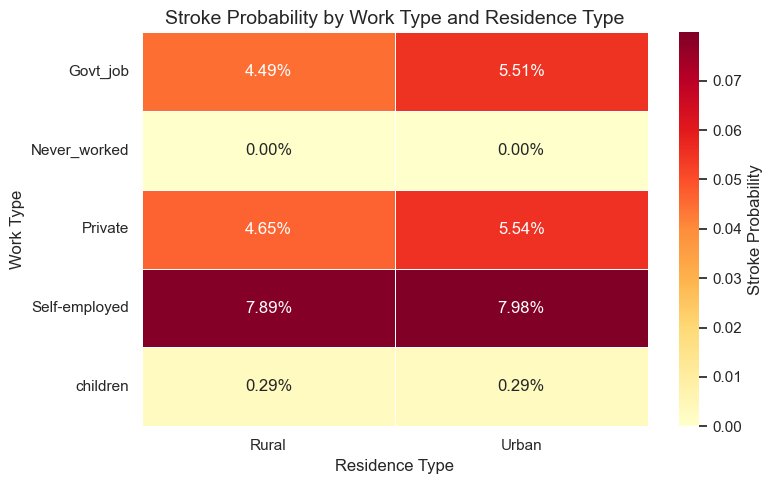

In [ ]:
pivot_stress = pd.pivot_table(
    df,
    values="stroke",
    index="work_type",
    columns="Residence_type",
    aggfunc="mean"
)

plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot_stress,
    annot=True,
    fmt=".2%",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={"label": "Stroke Probability"}
)

plt.title("Stroke Probability by Work Type and Residence Type", fontsize=14)
plt.xlabel("Residence Type")
plt.ylabel("Work Type")
plt.tight_layout()
plt.show()

## Categorical Risk Breakdown: Smoking Status

In this section, we compute the percentage of stroke cases within each smoking status category.

### Bottom Line  
Stroke probability varies across smoking categories.

### Interpretation  
Smoking history is a known vascular risk factor, so higher stroke rates among current or former smokers are expected. The "Unknown" group may represent a distinct population pattern rather than purely missing data.

In [ ]:
display(pd.crosstab(df["smoking_status"], df["stroke"], normalize="index") * 100)

stroke,0,1
smoking_status,,
Unknown,96.955959,3.044041
formerly smoked,92.081448,7.918552
never smoked,95.243129,4.756871
smokes,94.676806,5.323194


## Smoking Status and Stroke Risk

This analysis examines the relationship between smoking status and stroke probability.
We compare the proportion of stroke cases within each smoking category to understand how stroke risk varies across groups.

### **Bottom Line**

Stroke probability differs across smoking status categories.

### **Interpretation**

Groups with a history of smoking show higher stroke probability compared to those who never smoked, suggesting a potential association between smoking and stroke risk. The “Unknown” category also differs from other groups, indicating it may represent a distinct population segment rather than random missing data. 

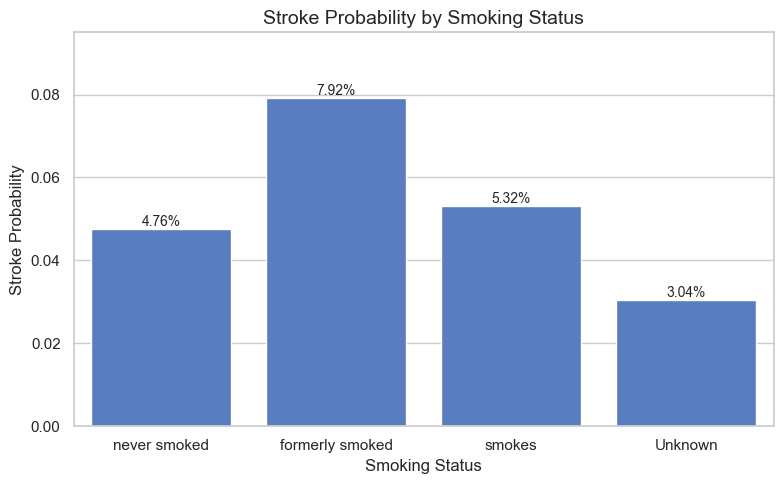

In [ ]:
smoking_prob = (
    df.groupby("smoking_status")["stroke"].mean()
    .reindex(["never smoked", "formerly smoked", "smokes", "Unknown"])
    .reset_index()
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x="smoking_status", y="stroke", data=smoking_prob)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2%}",
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha="center", va="bottom", fontsize=10
    )

plt.title("Stroke Probability by Smoking Status", fontsize=14)
plt.xlabel("Smoking Status")
plt.ylabel("Stroke Probability")
plt.ylim(0, smoking_prob["stroke"].max() * 1.2)
plt.tight_layout()
plt.show()


## “Missing Data” Detective: Smoking Status 

In this section, we investigate the group labeled as "Unknown" in the smoking_status column.

Instead of treating it only as missing data, we compare the age distributions across smoking status categories using density plots.
This helps determine whether "Unknown" behaves like a random missing group or represents a distinct population segment.

### **Bottom Line**

The “Unknown” smoking group shows a distinct age distribution.

### **Interpretation**

Rather than behaving like random missing data, the "Unknown" category appears to represent a specific demographic pattern. This suggests that "Unknown" may reflect age-related response differences rather than simple data absence.

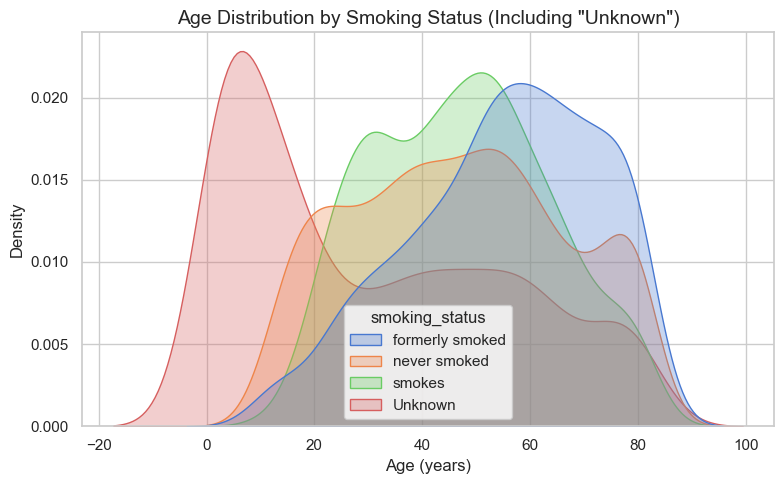

In [ ]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df,
    x="age",
    hue="smoking_status",
    fill=True,
    common_norm=False,
    alpha=0.3
)

plt.title('Age Distribution by Smoking Status (Including "Unknown")', fontsize=14)
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

## Categorical Risk Breakdown: Vascular Conditions

Here we examine stroke percentages for key vascular conditions: hypertension and heart disease.

### Bottom Line  
Stroke probability is substantially higher among individuals with hypertension or heart disease.

### Interpretation  
These findings align with clinical knowledge that vascular conditions significantly increase stroke risk and likely represent some of the strongest predictors in the dataset.


In [ ]:
display(pd.crosstab(df["hypertension"], df["stroke"], normalize="index") * 100)

stroke,0,1
hypertension,,
0,96.031230,3.968770
1,86.746988,13.253012


In [ ]:
display(pd.crosstab(df["heart_disease"], df["stroke"], normalize="index") * 100)

stroke,0,1
heart_disease,,
0,95.820401,4.179599
1,82.971014,17.028986


## Synergy of Vascular Risk Factors

In this section, we create a simple cumulative vascular risk score by summing two binary conditions:
hypertension and heart disease.

The score ranges from 0 to 2:
0 = none, 1 = one condition, 2 = both conditions.

We then compute and visualize the stroke probability for each risk score level to examine whether stroke risk increases as multiple vascular conditions accumulate.

### **Bottom Line**

Stroke probability increases substantially as vascular conditions accumulate.

### **Interpretation**

Individuals with either hypertension or heart disease show higher stroke probability compared to those with none, and those with both conditions exhibit the highest risk.

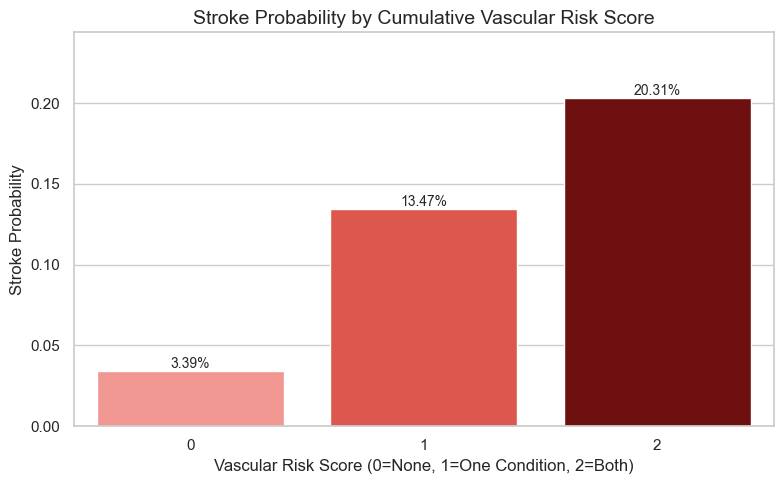

In [ ]:
df["vascular_risk_score"] = df["hypertension"] + df["heart_disease"]

risk_synergy = (
    df.groupby("vascular_risk_score")["stroke"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x="vascular_risk_score",
    y="stroke",
    data=risk_synergy,
    hue="vascular_risk_score",
    legend=False,
    palette=["#FF8A80", "#F44336", "#7F0000"]
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.2%}",                      
        (p.get_x() + p.get_width() / 2., height),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("Stroke Probability by Cumulative Vascular Risk Score", fontsize=14)
plt.xlabel("Vascular Risk Score (0=None, 1=One Condition, 2=Both)")
plt.ylabel("Stroke Probability")
plt.ylim(0, risk_synergy["stroke"].max() * 1.2)
plt.tight_layout()
plt.show()

## Relative Risk Analysis

This section computes the Relative Risk (RR) for several categorical risk factors.
RR compares the probability of stroke in two groups: with the factor vs. without the factor.

The dashed vertical line marks RR = 1, which represents the baseline (no difference in risk).
Values above 1 indicate higher stroke risk when the factor is present, while values below 1 indicate lower risk.

### **Bottom Line**

Hypertension and heart disease show the strongest associations with increased stroke risk.

### **Interpretation**

Relative Risk values above 1 indicate higher stroke probability in individuals with the factor compared to those without it. Vascular conditions such as hypertension and heart disease display the largest RR values, reinforcing their established role as major stroke risk factors. Other variables show weaker or near-neutral associations, suggesting a more limited independent effect.

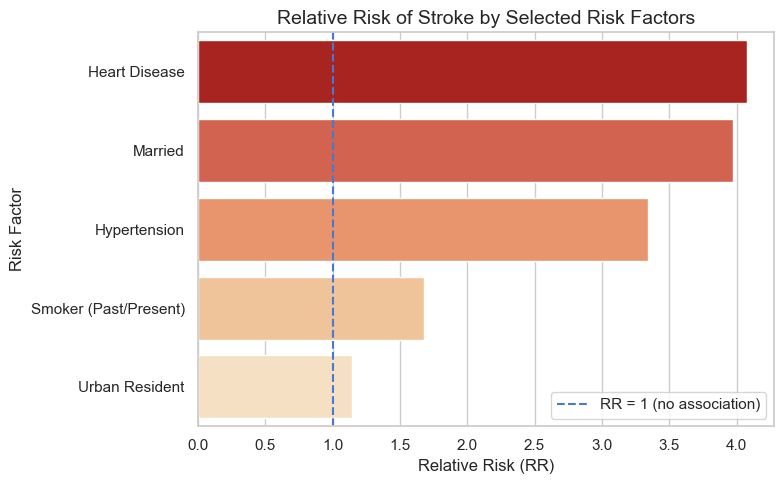

In [ ]:
def rr_binary(feature, positive_label=1):
    ct = pd.crosstab(df[feature], df["stroke"])
    risk1 = ct.loc[positive_label, 1] / ct.loc[positive_label].sum()
    risk0 = ct.loc[0, 1] / ct.loc[0].sum()
    return risk1 / risk0

def rr_category(feature, exposed_values, baseline_value):
    df_tmp = df.copy()
    df_tmp["exposed"] = df_tmp[feature].isin(exposed_values).astype(int)
    ct = pd.crosstab(df_tmp["exposed"], df_tmp["stroke"])
    risk1 = ct.loc[1, 1] / ct.loc[1].sum()
    risk0 = ct.loc[0, 1] / ct.loc[0].sum()
    return risk1 / risk0

rr_df = pd.DataFrame({
    "Factor": [
        "Heart Disease",
        "Married",
        "Hypertension",
        "Smoker (Past/Present)",
        "Urban Resident"
    ],
    "Relative Risk": [
        rr_binary("heart_disease"),
        rr_category("ever_married", ["Yes"], "No"),
        rr_binary("hypertension"),
        rr_category("smoking_status", ["formerly smoked", "smokes"], "never smoked"),
        rr_category("Residence_type", ["Urban"], "Rural")
    ]
})

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Relative Risk",
    y="Factor",
    data=rr_df,
    hue="Factor",
    legend=False,
    palette="OrRd_r"
)

plt.axvline(1.0, linestyle="--", label="RR = 1 (no association)")
plt.title("Relative Risk of Stroke by Selected Risk Factors", fontsize=14)
plt.xlabel("Relative Risk (RR)")
plt.ylabel("Risk Factor")
plt.legend()
plt.tight_layout()
plt.show()

## Final Insights and Conclusions

- Age emerged as the strongest continuous risk factor, with stroke probability increasing markedly with age.
- Average glucose levels showed a clear elevation in the stroke group, suggesting an important metabolic contribution.
- BMI demonstrated substantial overlap between groups, indicating a weaker standalone association with stroke.
- The combined presence of hypertension and heart disease substantially increased stroke risk, highlighting a synergistic vascular effect.
- Overall, stroke risk appears to be driven by an interaction between demographic, metabolic, and vascular factors rather than any single variable alone.
